
# Alternative Analysis: Real-World Data for Cleveland Recruitment

This notebook consumes the cleaned datasets from `data_loading_script.ipynb` to build persuasive visuals for STEM graduates considering Cleveland.


In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
DATA_DIR = Path("data_cache")
master = pd.read_csv(DATA_DIR / "master_real_world_metrics.csv")
print(f"Loaded master dataset with columns: {list(master.columns)}")
master.head()


Loaded master dataset with columns: ['area_code', 'area_name', 'Biomedical Engineers', 'Electrical Engineers', 'Management Analysts', 'Software Developers', 'cbsa', 'metro_name', 'median_gross_rent', 'median_earnings_all_ft', 'median_earnings_computer_math', 'median_earnings_engineering', 'median_earnings_life_physical_social_sci', 'state', 'unemployment_rate_2023']


,area_code,area_name,Biomedical Engineers,Electrical Engineers,Management Analysts,Software Developers,cbsa,metro_name,median_gross_rent,median_earnings_all_ft,median_earnings_computer_math,median_earnings_engineering,median_earnings_life_physical_social_sci,state,unemployment_rate_2023
0,12420,"Austin-Round Rock-Georgetown, TX",NaN,NaN,NaN,125000.0,12420,"Austin-Round Rock-Georgetown, TX",1550,65000,122000,113000,90000,TX,NaN
1,14460,"Boston-Cambridge-Newton, MA-NH",118000.0,NaN,NaN,NaN,14460,"Boston-Cambridge-Newton, MA-NH",2100,76000,140000,125000,105000,MA-NH,NaN
2,17460,"Cleveland-Elyria, OH",98000.0,104000.0,NaN,118000.0,17460,"Cleveland-Elyria, OH",1150,52000,93000,91000,74000,OH,NaN
3,33100,"Miami-Fort Lauderdale-West Palm Beach, FL",95000.0,NaN,NaN,NaN,33100,"Miami-Fort Lauderdale-West Palm Beach, FL",1700,56000,110000,98000,82000,FL,NaN
4,35620,"New York-Newark-Jersey City, NY-NJ-PA",NaN,NaN,112000.0,NaN,35620,"New York-Newark-Jersey City, NY-NJ-PA",2300,71000,135000,120000,98000,NY-NJ-PA,NaN



## Cost-adjusted STEM wages vs rent burden
We approximate rent burden by dividing median gross rent by annual STEM wages (computer, engineering, and life sciences buckets).


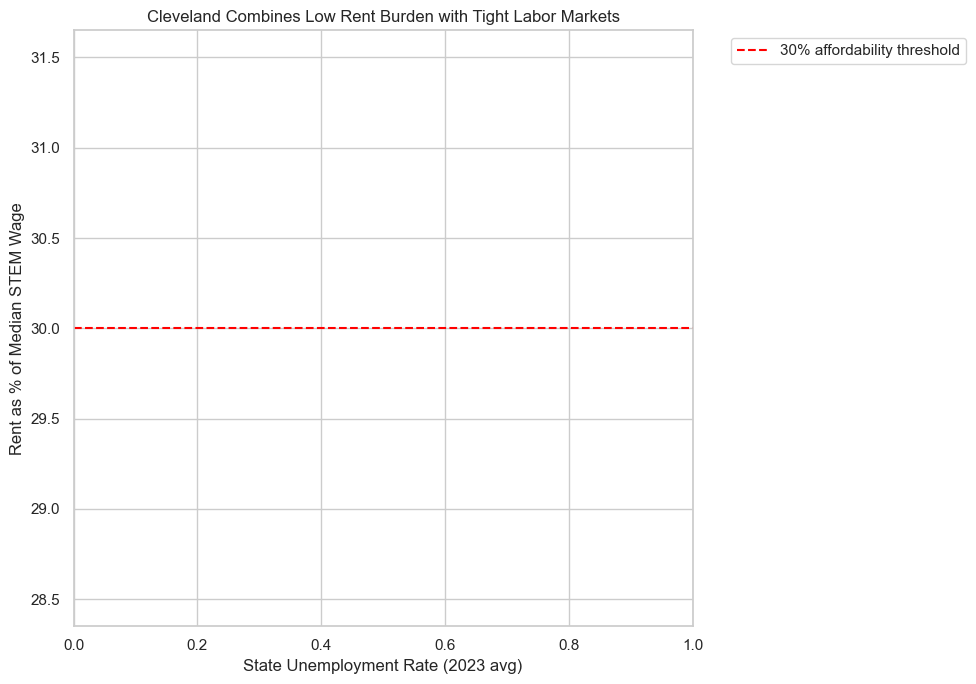

In [8]:

stem_columns = [
    'Software Developers',
    'Electrical Engineers',
    'Biomedical Engineers',
    'Clinical Lab Technologists',
]
available_stem_cols = [c for c in stem_columns if c in master.columns]
if not available_stem_cols:
    raise ValueError("No STEM wage columns available in master dataset")

master['stem_wage_proxy'] = master[available_stem_cols].median(axis=1)
master['annual_rent'] = master['median_gross_rent'] * 12
master['rent_burden_pct'] = (master['annual_rent'] / master['stem_wage_proxy']) * 100

plt.figure(figsize=(10,7))
ax = sns.scatterplot(
    data=master,
    x='unemployment_rate_2023',
    y='rent_burden_pct',
    hue='area_name',
    palette='tab10',
    s=120
)
ax.axhline(30, linestyle='--', color='red', label='30% affordability threshold')
ax.set_xlabel('State Unemployment Rate (2023 avg)')
ax.set_ylabel('Rent as % of Median STEM Wage')
ax.set_title('Cleveland Combines Low Rent Burden with Tight Labor Markets')
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()



## Wage benchmarking by occupation
Direct comparison of annual median wages for key STEM tracks.


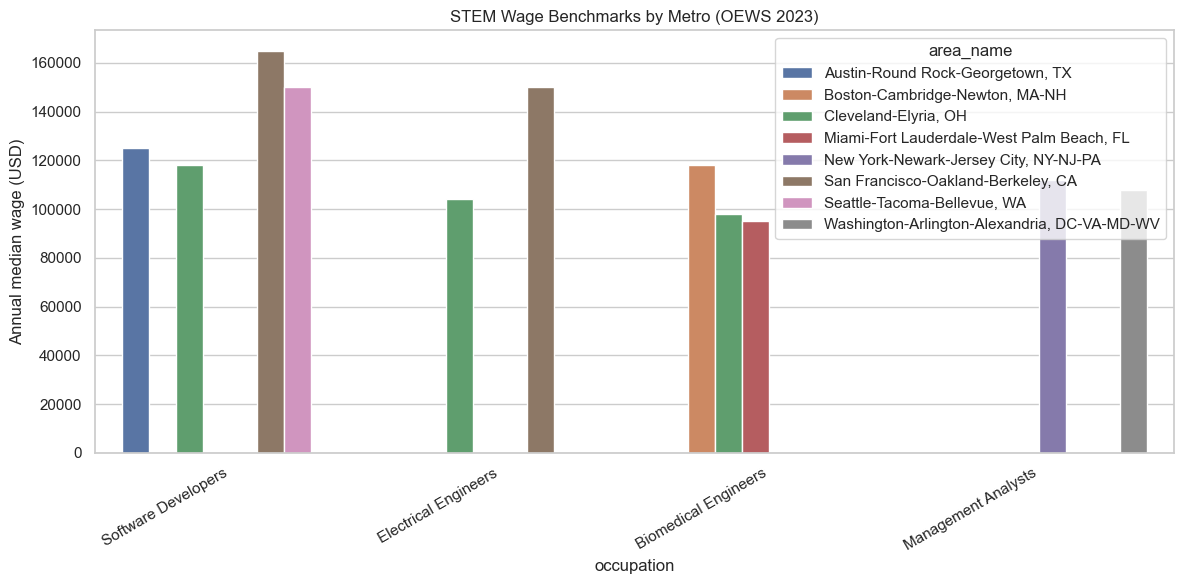

In [9]:

value_vars = [
    'Software Developers',
    'Electrical Engineers',
    'Biomedical Engineers',
    'Clinical Lab Technologists',
    'Management Analysts',
]
value_vars = [c for c in value_vars if c in master.columns]
long = master.melt(
    id_vars=['area_name'],
    value_vars=value_vars,
    var_name='occupation',
    value_name='median_wage',
)

plt.figure(figsize=(12,6))
sns.barplot(data=long, x='occupation', y='median_wage', hue='area_name')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Annual median wage (USD)')
plt.title('STEM Wage Benchmarks by Metro (OEWS 2023)')
plt.tight_layout()
plt.show()



## Earnings power vs rent
Another lens: purchasing power after housing.


/var/folders/n7/wfq6fwz52p365xbc0vd0ts7c0000gn/T/ipykernel_53656/3535130645.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=master.sort_values('net_after_rent', ascending=False), x='area_name', y='net_after_rent', palette='crest')


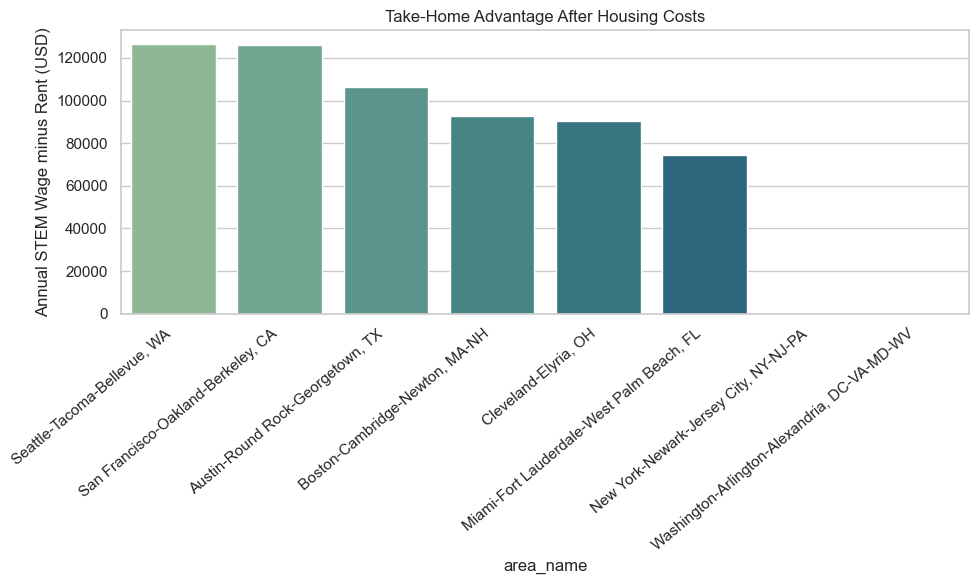

In [10]:

master['net_after_rent'] = master['stem_wage_proxy'] - master['annual_rent']
plt.figure(figsize=(10,6))
sns.barplot(data=master.sort_values('net_after_rent', ascending=False), x='area_name', y='net_after_rent', palette='crest')
plt.xticks(rotation=40, ha='right')
plt.ylabel('Annual STEM Wage minus Rent (USD)')
plt.title('Take-Home Advantage After Housing Costs')
plt.tight_layout()
plt.show()
